## Here we study the influence of alpha in q-learning:
\alpha is the learning rate of q-laerning and sarsa algorithm.

Generallly speaking,The learning rate should be in the range of 0 -1. The higher the learning rate, it quickly replaces the new q value. We need to optimize it in a way so that our agent learns from the previous q values. A learning rate is a tool that can be used to find how much we keep our previous knowledge of our experience that needs to keep for our state-action pairs.

In [23]:
import gymnasium as gym
import sumo_rl
import numpy as np
from sumo_rl import SumoEnvironment
from sumo_rl.agents import QLAgent
from sumo_rl.exploration import EpsilonGreedy

# 4x4 grid
we chosed a complicated environment to train the agents, the processe is as follows:

    * initiate the environment of 4x4 grid road, noticing that it shuold contain 16 traffice lights, meaning that we need to train 16 agents
    * train each agent seperately with q-learning / sarsa method using different alpha value ( here we studied 0.1 and 0.01) 
    * ploting the reward at each time step ( the default reward is waiting time, the smaller it is, the performence is better 
    
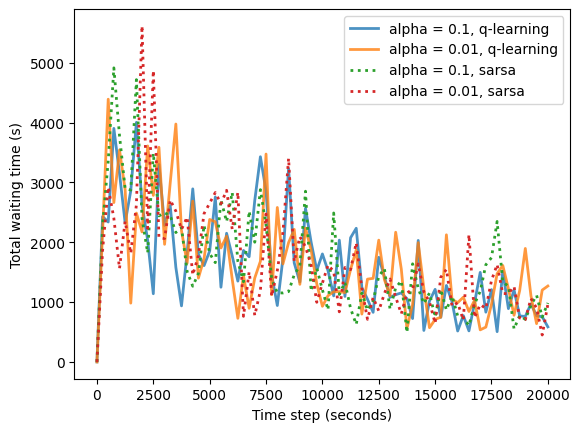

This figure shows the reward fuction ( waiting time ) during the training process. Our goal is to minimizing waiting time , so we shuold have a declining curve. As we kept training for a long time, the rewards shuold be minimized as much as possible.

We've studied four conditions: 

    * q-learning with alpha = 0.1
    * q-learning with alpha = 0.01
    * sarsa with alpha = 0.1
    * sarsa with alpha = 0.01

We can see from the figure:

(1) generally speaking, q-learning learns faster than sarsa. For both learning rates, q-learning only need 2500 steps to get a waiting time of 1000s, but it took around 7500 steps for the sarsa algorithm.

(2) For both q-learning and sarsa, increasing alpha from 0.01 to 0.01 can slightly accelerate the training. For example, at step 2000 for sarsa method, the waiting time is around 4000s for alpha = 0.01 but waitingtime is around 3000s for alpha = 0.1. The same thing could be find with q-learning algorithm, at step 2500, waiting time is 2500s for alpha =0.01 and 1500s for alpha = 0.1. 

(3) In the long term, alpha won't change the final reward. And alpha regarded as learning rate does not influence the excecution time our training process, as previous studies showed that in this non-stationary state without a read "end", q-learng and sarsa metheod only teminates when we have get the setted num_seconds. So deciding a good num_second is more important than parameter-tuning of the learning rates in those algorithms.

In conclusion , in this case of 4x4 grid road, choose an aplha = 0.1 is appropriate for both q-learning and sarsa method, and both method could obtain the same results in the end.

   




    

## Q-learning
###  build the environment of 4x4 grid

In [24]:
env = SumoEnvironment(net_file='nets/4x4-Lucas/4x4.net.xml',
                          route_file='nets/4x4-Lucas/4x4c1c2c1c2.rou.xml',
                          use_gui=False,
                          num_seconds=20000,
                          min_green=5,
                          delta_time=5)

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 0 ACT 0 BUF 0)                     


In [31]:
def evaluate_alpha(alpha):
    initial_states = env.reset()
    ql_agents = {ts: QLAgent(starting_state=env.encode(initial_states[ts], ts),
                                 state_space=env.observation_space,
                                 action_space=env.action_space,
                                 alpha=alpha,
                                 gamma=0.99,
                                 exploration_strategy=EpsilonGreedy(initial_epsilon=0.05, min_epsilon=0.005))
             for ts in env.ts_ids}
    infos = []
    done = {'__all__': False}
    while not done['__all__']:
        actions = {ts: ql_agents[ts].act() for ts in ql_agents.keys()}

        s, r, done, info = env.step(action=actions)

        for agent_id in s.keys():
            ql_agents[agent_id].learn(next_state=env.encode(s[agent_id], agent_id), reward=r[agent_id])
    outputname = 'outputs/4x4/alpha/ql-4x4grid-'+str(alpha)
    env.save_csv(outputname, 1)
    env.close()
    

In [32]:
evaluate_alpha(0.01)

 Retrying in 1 seconds
Step #8900.00 (6ms ~= 166.67*RT, ~95500.00UPS, TraCI: 141ms, vehicles TOT 20465 ACT 573 BUtep #4500.00 (4ms ~= 250.00*RT, ~129000.00UPS, TraCI: 131ms, vehicles TOT 9813 ACT 516 BU

Exception ignored in: <function SumoEnvironment.__del__ at 0x7ff4e3329d80>
Traceback (most recent call last):
  File "/home/wen/Documents/project-rl/sumo-rl-master/sumo_rl/environment/env.py", line 377, in __del__
    self.close()        
  File "/home/wen/Documents/project-rl/sumo-rl-master/sumo_rl/environment/env.py", line 370, in close
    traci.close()
  File "/home/wen/.local/lib/python3.10/site-packages/traci/main.py", line 245, in close
    connection.check().close(wait)
  File "/home/wen/.local/lib/python3.10/site-packages/traci/connection.py", line 391, in close
    self._sendCmd(tc.CMD_CLOSE, None, None)
  File "/home/wen/.local/lib/python3.10/site-packages/traci/connection.py", line 225, in _sendCmd
    return self._sendExact()
  File "/home/wen/.local/lib/python3.10/site-packages/traci/connection.py", line 135, in _sendExact
    raise FatalTraCIError("connection closed by SUMO")
traci.exceptions.FatalTraCIError: connection closed by SUMO
Exception ignored in: <function Sumo

Step #6140.00 (4ms ~= 250.00*RT, ~64750.00UPS, TraCI: 2197436ms, vehicles TOT 8368 ACT 259
Step #20005.00 (5ms ~= 200.00*RT, ~103600.00UPS, TraCI: 312ms, vehicles TOT 49555 ACT 518 p #13500.00 (7ms ~= 142.86*RT, ~77142.86UPS, TraCI: 185ms, vehicles TOT 32240 ACT 540 B #18000.00 (7ms ~= 142.86*RT, ~82142.86UPS, TraCI: 112ms, vehicles TOT 44180 ACT 575 B


In [ ]:
evaluate_alpha(0.001)

## SARSA 
We've implemented the SARSA algorithm here, and adapted it, now it can directly train the agents in sumo-rl enviroment without calling gym to make the environment

In [35]:
class SARSAAgent:

    def __init__(self, starting_state, state_space, action_space, alpha=0.5, gamma=0.95, exploration_strategy=EpsilonGreedy()):
        self.state = starting_state
        self.state_space = state_space
        self.action_space = action_space
        self.action = None
        self.alpha = alpha
        self.gamma = gamma
        self.q_table = {self.state: [0 for _ in range(action_space.n)]}
        self.exploration = exploration_strategy
        self.acc_reward = 0

    def act(self):
        self.action = self.exploration.choose(self.q_table, self.state, self.action_space)
        return self.action

    def learn(self, next_state, reward, done=False):
    
        if next_state not in self.q_table:
            self.q_table[next_state] = [0 for _ in range(self.action_space.n)]

        s = self.state
        s1 = next_state
        a = self.action
        a1 = self.exploration.choose(self.q_table, next_state, self.action_space)
        
        self.q_table[s][a] = self.q_table[s][a] + self.alpha*(reward + self.gamma*self.q_table[s1][a1] - self.q_table[s][a])
        self.state = s1
        self.action = a1
        
        self.acc_reward += reward
        

In [36]:
def evaluate_alpha_sarsa(alpha):
    initial_states = env.reset()
    ss_agents = {ts: SARSAAgent(starting_state=env.encode(initial_states[ts], ts),
                                 state_space=env.observation_space,
                                 action_space=env.action_space,
                                 alpha=alpha,
                                 gamma=0.99,
                                 exploration_strategy=EpsilonGreedy(initial_epsilon=0.05, min_epsilon=0.005))
             for ts in env.ts_ids}
    infos = []
    done = {'__all__': False}
    while not done['__all__']:
        actions = {ts: ss_agents[ts].act() for ts in ss_agents.keys()}

        s, r, done, info = env.step(action=actions)

        for agent_id in s.keys():
            ss_agents[agent_id].learn(next_state=env.encode(s[agent_id], agent_id), reward=r[agent_id])
    outputname = 'outputs/4x4/alpha/ss-4x4grid-'+str(alpha)
    env.save_csv(outputname, 1)
    env.close()
    

In [37]:
env = SumoEnvironment(net_file='nets/4x4-Lucas/4x4.net.xml',
                          route_file='nets/4x4-Lucas/4x4c1c2c1c2.rou.xml',
                          use_gui=False,
                          num_seconds=20000,
                          min_green=5,
                          delta_time=5)

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 0 ACT 0 BUF 0)                     


In [38]:
evaluate_alpha_sarsa(0.1)

 Retrying in 1 seconds
Step #20005.00 (6ms ~= 166.67*RT, ~91833.33UPS, TraCI: 456ms, vehicles TOT 49696 ACT 551 Btep #4500.00 (4ms ~= 250.00*RT, ~129500.00UPS, TraCI: 101ms, vehicles TOT 9874 ACT 518 BUep #9000.00 (6ms ~= 166.67*RT, ~92833.33UPS, TraCI: 112ms, vehicles TOT 20653 ACT 557 BUp #13500.00 (7ms ~= 142.86*RT, ~77142.86UPS, TraCI: 303ms, vehicles TOT 32186 ACT 540 B #18000.00 (7ms ~= 142.86*RT, ~81857.14UPS, TraCI: 251ms, vehicles TOT 44228 ACT 573 B


In [43]:
evaluate_alpha_sarsa(0.01)

 Retrying in 1 seconds
Step #20005.00 (5ms ~= 200.00*RT, ~100400.00UPS, TraCI: 431ms, vehicles TOT 49823 ACT 502 tep #4500.00 (5ms ~= 200.00*RT, ~104200.00UPS, TraCI: 103ms, vehicles TOT 9894 ACT 521 BUep #9000.00 (4ms ~= 250.00*RT, ~135500.00UPS, TraCI: 103ms, vehicles TOT 20699 ACT 542 Bp #13500.00 (6ms ~= 166.67*RT, ~92000.00UPS, TraCI: 255ms, vehicles TOT 32388 ACT 552 B #18000.00 (7ms ~= 142.86*RT, ~74857.14UPS, TraCI: 251ms, vehicles TOT 44366 ACT 524 B


## plot figure

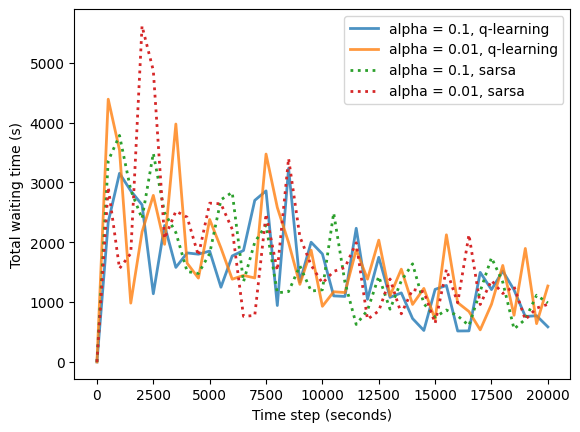

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
r01a= pd.read_csv('outputs/4x4/alpha/ql-4x4grid-01_conn10_run1.csv')  
r001a= pd.read_csv('outputs/4x4/alpha/ql-4x4grid-0.01_conn10_run1.csv')  
r01ass= pd.read_csv('outputs/4x4/alpha/ss-4x4grid-0.1_conn11_run1.csv')  
r001ass= pd.read_csv('outputs/4x4/alpha/ss-4x4grid-0.01_conn11_run1.csv') 
# r0001a= pd.read_csv('outputs/single-intersection/alpha/output0001speed_conn5_run1.csv') 

plt.plot(r01a['step'].iloc[::100], r01a['system_total_waiting_time'].iloc[::100], label='alpha = 0.1, q-learning',linewidth=2,alpha=0.8)
plt.plot(r001a['step'].iloc[::100], r001a['system_total_waiting_time'].iloc[::100], label='alpha = 0.01, q-learning',linewidth=2,alpha=0.8)
plt.plot(r01ass['step'].iloc[::100], r01ass['system_total_waiting_time'].iloc[::100], linestyle='dotted',label='alpha = 0.1, sarsa',linewidth=2)
plt.plot(r001ass['step'].iloc[::100], r001ass['system_total_waiting_time'].iloc[::100],linestyle='dotted', label='alpha = 0.01, sarsa',linewidth=2)

plt.xlabel('Time step (seconds)')
plt.ylabel('Total waiting time (s)')

plt.legend()
plt.show()